# Converting the CMIP6 Data Set to the OpenVisus Visualization Format

This Jupyter notebook provides an example of how one might take a portion of the CMIP6 Data Set and convert it to the OpenVisus Visualization Format.

## Assumptions

1. You are running this notebook via [OSG's OSPool Notebooks service](https://notebook.ospool.osg-htc.org) as a user of ap40.uw.osg-htc.org.

2. You have run through the steps in [the setup notebook](cmip6_setup.ipynb).

3. You have selected the `openvisuspy` kernel for this notebook via the Jupyter interface.

4. You have a token stored in the file `osdf.token` that authorizes the bearer to write into NSDF's namespace prefix within OSDF (see `pelican_loc`, defined below).

## (Optional) Ensure that job credentials are available

This step is necessary only to work around a bug or misconfiguration. Normally, these credentials are handled by HTCondor automatically.

In [1]:
!echo | condor_store_cred add-oauth -s scitokens -i -

Account: <current> (brian.aydemir)
CredType: oauth

Operation succeeded and is waiting for processing.

Credential info:
fully_qualified_user = "brian.aydemir@ap40.uw.osg-htc.org"



## Submit the job

Set `container_image` to the location of the `openvisuspy` container image that you created in [the setup notebook](cmip6_setup.ipynb).

Set `ds_object` to the NetCDF file that you wish to convert.

Set `pelican_loc` to the location in a Pelican federation, e.g., OSDF, where the OpenVisus index should be copied to.

In [2]:
## Define the container image for the OpenVisus software stack.

container_image = "osdf://ospool/ap40/data/brian.aydemir/openvisuspy-20240812-1020.sif"


## Define the object to convert.

aws_opendata_prefix = "osdf://aws-opendata/us-west-2"
ds_object = "nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/hurs/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc"


## Define where to store the OpenVisus output.

destination_dir = "openvisus"
pelican_loc = "pelican://osg-htc.org/nsdf/testing/20240917/v1"

In [3]:
import htcondor
import pathlib


## Record information about where this notebook is running

hostname, = !hostname


## Remove log files from previous runs.

for ext in [".log", ".out", ".err"]:
    pathlib.Path(f"convert_dataset{ext}").unlink(missing_ok=True)


## Submit the job.

job_description = htcondor.Submit(
    f"""
    container_image = {container_image}
    args = python3 convert_dataset.py {destination_dir} $BASENAME({ds_object}) {pelican_loc}

    transfer_input_files = convert_dataset.py, {aws_opendata_prefix}/{ds_object}, pelican, osdf.token

    ## Use the backfill EP provided by the OSPool Notebooks service.
    requirements = Machine == "CHTC-Jupyter-User-EP.{hostname}"
    +FromJupyter = true

    ## Configure the Pelican client.
    environment = "PELICAN_CLIENT_WORKERCOUNT=4 PELICAN_LOGGING_DISABLEPROGRESSBARS=true"
    
    ## Save the job log, and standard output and error.
    log = convert_dataset.log
    output = convert_dataset.out
    error = convert_dataset.err

    ## Specify resource requests and other requirements.
    request_cpus = 2
    request_memory = 4G
    request_disk = 4G

    ## Make it easier to monitor and follow-up on "failed" jobs.                              
    stream_output = true
    stream_error = true
    on_exit_hold = ExitCode =!= 0
    """
)

submitted_job = htcondor.Schedd().submit(job_description)

## Wait for the job to complete

In [4]:
import demo_support

demo_support.wait_for_job(f"convert_dataset.log")

[2024-09-17 10:28:31] Job submitted.
[2024-09-17 10:29:06] Started transferring input files.
[2024-09-17 10:29:37] Finished transferring input files.
[2024-09-17 10:29:39] Job executing on host CHTC-Jupyter-User-EP.jupyter-eppn-3abaydemir-40wisc-2eedu.
[2024-09-17 10:34:20] Finished transferring output files.
[2024-09-17 10:34:20] Job terminated.
[2024-09-17 15:34:20] Done monitoring the job's log file.


## Visualize the dataset

### Import libraries

In [5]:
import IPython.display
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import OpenVisus
import openvisuspy as ov

### Load the dataset

In [6]:
dataset_loc = f"{pelican_loc}/visus.idx?directread"
db = ov.LoadDataset(dataset_loc)

Note: Pelican's `directread` option here should only be necessary when there are problems with its internal caching infrastructure.

### Show some basic information

In [7]:
print("Dataset loaded from:", dataset_loc)
print("Dimensions:", db.getLogicBox())
print("Total Timesteps:", len(db.getTimesteps()))
print("Field:", db.getField().name)

Dataset loaded from: pelican://osg-htc.org/nsdf/testing/20240917/v1/visus.idx?directread
Dimensions: ([0, 0], [1440, 600])
Total Timesteps: 366
Field: hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn


### Animate the data

Only a few timestemps are chosen (see the definition of `animation`) for the purposes of illustration.

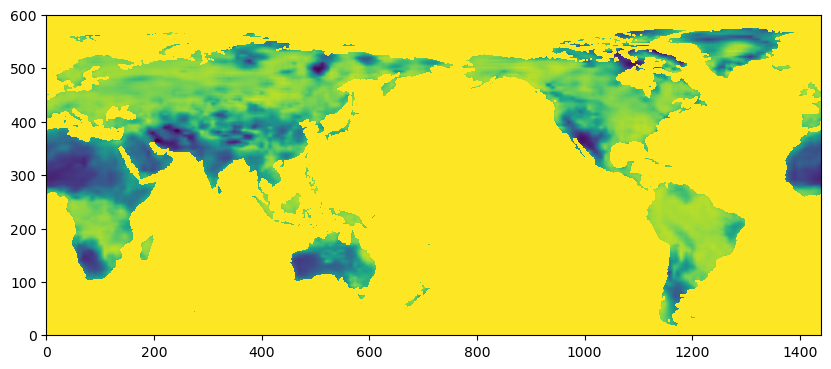

In [8]:
## Extract dimensions from the first timestep.

quality = 0  # full resolution = 0, coarse = -4, coarser = -8
timestep = db.getTimesteps()[0]
data3D = db.db.read(time=timestep, quality=quality)
data = data3D[:,:]
H, W = data3D.shape


## Define and show the animation.

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10 * H / W))
axes.set_xlim(0, W)
axes.set_ylim(0, H)
# TODO: Determine how to set `vmin` and `vmax`.
image = axes.imshow(data, extent=[0, W, 0, H], aspect="auto", origin="lower", vmax=110, cmap="viridis")

def frame_fn(timestep):
    data3D = db.db.read(time=timestep, quality=quality)
    data = data3D[:,:]
    image.set_data(data)

plt.rcParams["animation.embed_limit"] = 100  # MB
animation = matplotlib.animation.FuncAnimation(fig, frame_fn, frames=db.getTimesteps()[4:8])
IPython.display.HTML(animation.to_jshtml())